1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, f1_score, confusion_matrix, roc_curve
from joblib import dump
import warnings
warnings.filterwarnings('ignore')

2. Load Data

In [3]:
df = pd.read_csv(r"C:\Users\Cooper\Downloads\Telco-Customer-Churn.csv")
print("Shape of dataset:", df.shape)
print(df.head())

# Display settings
pd.set_option('display.max_columns', None)
sns.set(style="whitegrid")

Shape of dataset: (7043, 21)
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV Streami

3. Exploratory Data Analysis (EDA)

In [4]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [5]:
print(df.describe())

       SeniorCitizen       tenure  MonthlyCharges
count    7043.000000  7043.000000     7043.000000
mean        0.162147    32.371149       64.761692
std         0.368612    24.559481       30.090047
min         0.000000     0.000000       18.250000
25%         0.000000     9.000000       35.500000
50%         0.000000    29.000000       70.350000
75%         0.000000    55.000000       89.850000
max         1.000000    72.000000      118.750000


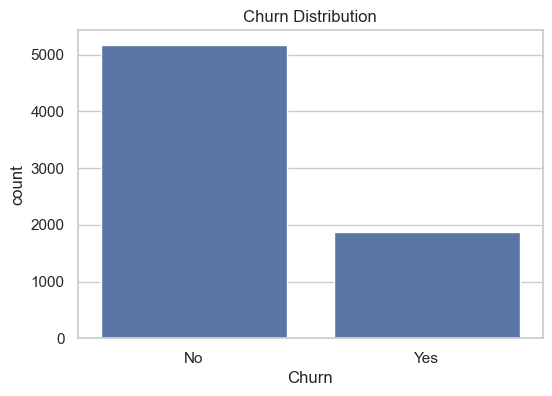

In [6]:
# Churn distribution
plt.figure(figsize=(6,4))
sns.countplot(x='Churn', data=df)
plt.title("Churn Distribution")
plt.show()

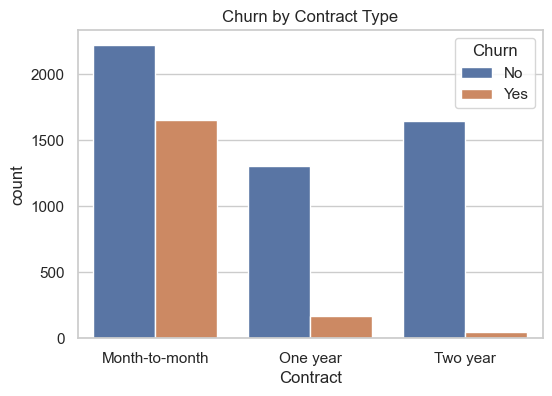

In [7]:
# Churn by contract type
if 'Contract' in df.columns:
    plt.figure(figsize=(6,4))
    sns.countplot(x='Contract', hue='Churn', data=df)
    plt.title("Churn by Contract Type")
    plt.show()

4. Data Preprocessing

In [8]:
# Convert TotalCharges to numeric
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)

In [9]:
# Encode categorical variables
df = pd.get_dummies(df, drop_first=True)

In [10]:
# Feature-target split
X = df.drop('Churn_Yes', axis=1)
y = df['Churn_Yes']

In [11]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
# Scale numerical features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

5. Baseline Logistic Regression

In [13]:
log_model = LogisticRegression()
log_model.fit(X_train, y_train)
y_pred_log = log_model.predict(X_test)

log_auc = roc_auc_score(y_test, log_model.predict_proba(X_test)[:,1])
log_f1 = f1_score(y_test, y_pred_log)
log_acc = accuracy_score(y_test, y_pred_log)

print("\nLogistic Regression Report:")
print(classification_report(y_test, y_pred_log))
print("ROC-AUC:", log_auc)


Logistic Regression Report:
              precision    recall  f1-score   support

       False       0.80      0.96      0.87      1036
        True       0.72      0.32      0.44       373

    accuracy                           0.79      1409
   macro avg       0.76      0.64      0.65      1409
weighted avg       0.78      0.79      0.75      1409

ROC-AUC: 0.8566240024014822


6. Random Forest (with basic hyperparameter tuning)

In [14]:
rf_model = RandomForestClassifier(random_state=42)
rf_params = {'n_estimators': [100, 200],
             'max_depth': [5, 10, None]}
rf_grid = GridSearchCV(rf_model, rf_params, cv=3, scoring='roc_auc', n_jobs=-1)
rf_grid.fit(X_train, y_train)
rf_best = rf_grid.best_estimator_

y_pred_rf = rf_best.predict(X_test)
rf_auc = roc_auc_score(y_test, rf_best.predict_proba(X_test)[:,1])
rf_f1 = f1_score(y_test, y_pred_rf)
rf_acc = accuracy_score(y_test, y_pred_rf)

print("\nRandom Forest Best Params:", rf_grid.best_params_)
print("ROC-AUC:", rf_auc)


Random Forest Best Params: {'max_depth': None, 'n_estimators': 200}
ROC-AUC: 0.8517511670996927


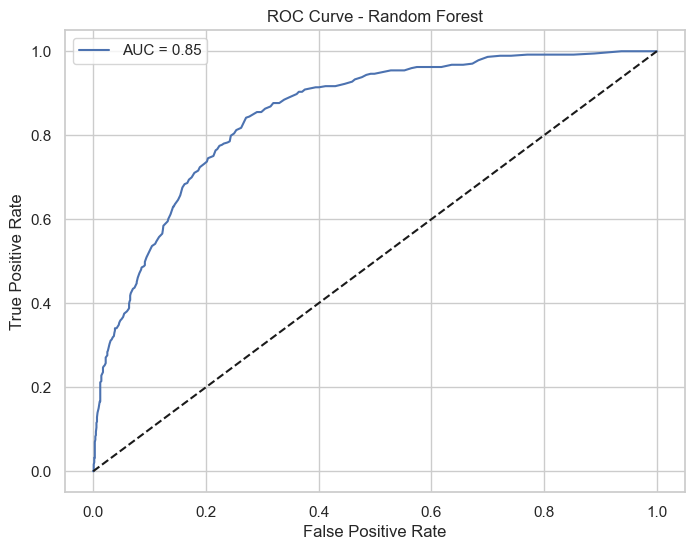

In [15]:
y_proba = rf_best.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_proba):.2f}")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Random Forest")
plt.legend()
plt.show()

7. XGBoost (with hyperparameter tuning)

In [16]:
xgb_model = XGBClassifier(eval_metric='logloss', random_state=42)
xgb_params = {'n_estimators': [100, 200],
              'max_depth': [3, 5, 7],
              'learning_rate': [0.01, 0.1]}
xgb_grid = GridSearchCV(xgb_model, xgb_params, cv=3, scoring='roc_auc', n_jobs=-1)
xgb_grid.fit(X_train, y_train)
xgb_best = xgb_grid.best_estimator_

y_pred_xgb = xgb_best.predict(X_test)
xgb_auc = roc_auc_score(y_test, xgb_best.predict_proba(X_test)[:,1])
xgb_f1 = f1_score(y_test, y_pred_xgb)
xgb_acc = accuracy_score(y_test, y_pred_xgb)

print("\nXGBoost Best Params:", xgb_grid.best_params_)
print("ROC-AUC:", xgb_auc)


XGBoost Best Params: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200}
ROC-AUC: 0.8605613464862796


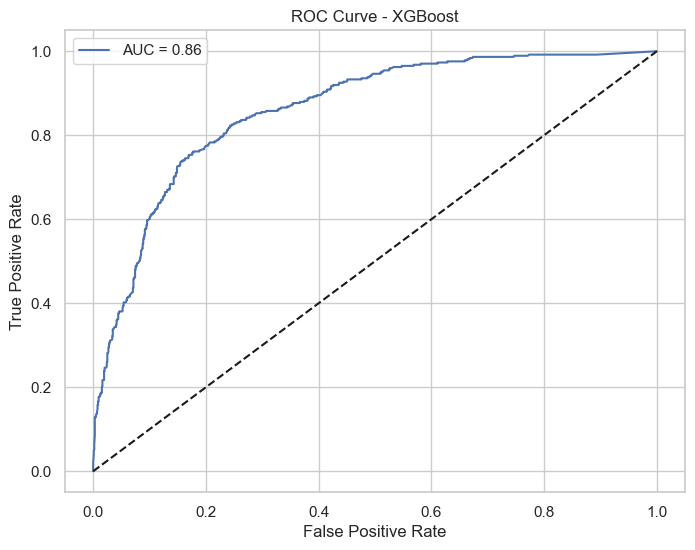

In [17]:
y_proba = xgb_best.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_proba):.2f}")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - XGBoost")
plt.legend()
plt.show()

8. Model Comparison

In [18]:
comparison = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'XGBoost'],
    'ROC-AUC': [log_auc, rf_auc, xgb_auc],
    'F1 Score': [log_f1, rf_f1, xgb_f1],
    'Accuracy': [log_acc, rf_acc, xgb_acc]
})

print("\nModel Comparison:\n", comparison.sort_values(by='ROC-AUC', ascending=False))


Model Comparison:
                  Model   ROC-AUC  F1 Score  Accuracy
2              XGBoost  0.860561  0.536825  0.799148
0  Logistic Regression  0.856624  0.439479  0.786373
1        Random Forest  0.851751  0.538710  0.797019


9. Save Best Model

In [19]:
best_model_name = comparison.loc[comparison['ROC-AUC'].idxmax(), 'Model']
best_model = {"Logistic Regression": log_model, "Random Forest": rf_best, "XGBoost": xgb_best}[best_model_name]

dump(best_model, "best_churn_model.joblib")
print(f"\nBest model ({best_model_name}) saved as best_churn_model.joblib")


Best model (XGBoost) saved as best_churn_model.joblib


10. Churn Probability Report

In [20]:
proba_df = pd.DataFrame({
    'Churn_Probability': best_model.predict_proba(X_test)[:,1],
    'Actual_Churn': y_test.reset_index(drop=True)
})
proba_df['Predicted_Churn'] = (proba_df['Churn_Probability'] >= 0.5).astype(int)
proba_df.to_csv("churn_probability_report.csv", index=False)
print("\nChurn probability report saved as churn_probability_report.csv")


Churn probability report saved as churn_probability_report.csv


11. Feature Importance (Top 10)

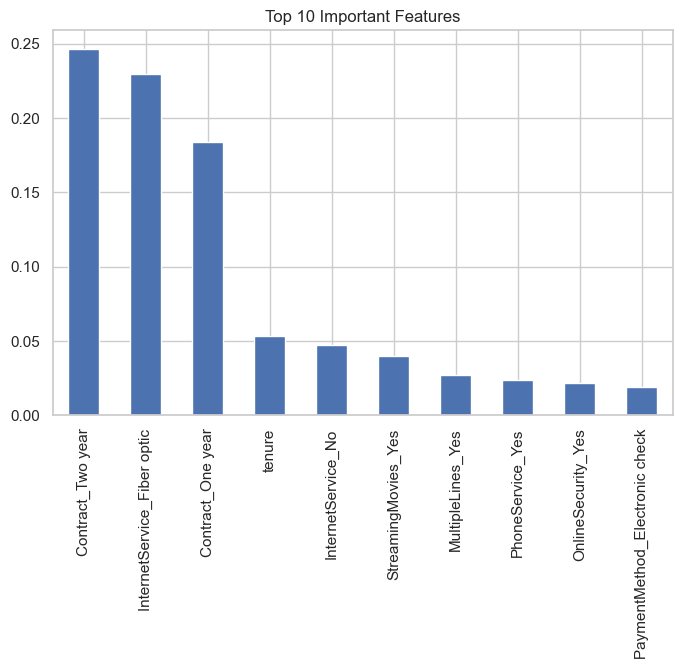

In [21]:
if best_model_name in ['Random Forest', 'XGBoost']:
    importances = best_model.feature_importances_
    features = pd.Series(importances, index=df.drop('Churn_Yes', axis=1).columns).sort_values(ascending=False)

    plt.figure(figsize=(8,5))
    features[:10].plot(kind='bar')
    plt.title("Top 10 Important Features")
    plt.show()

12. Insights

In [22]:
print("\nBusiness Insights:")
print("- Month-to-month contracts and high monthly charges strongly indicate churn.")
print("- Long-tenure customers are less likely to churn.")
print("- Target retention offers to high-risk segments identified in report.")


Business Insights:
- Month-to-month contracts and high monthly charges strongly indicate churn.
- Long-tenure customers are less likely to churn.
- Target retention offers to high-risk segments identified in report.
